In [67]:
import numpy as np
from qiskit.opflow import I, X, Y, Z, MatrixEvolution, PauliTrotterEvolution
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit import QuantumCircuit, execute
import pylatexenc
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
from matplotlib import pyplot as plt
import math 
import time 

In [68]:
def depth(qc):
  depth_list = []
  depth_list.append(qc.depth())
  for i in range(5):
    qc = qc.decompose()
    depth_list.append(qc.depth())
  if(depth_list[-1]==depth_list[-2]):
    return depth_list[-1]
  else:
    while(depth_list[-1]!=depth_list[-2]):
      qc = qc.decompose()
      depth_list.append(qc.depth())
    else:
      return depth_list[-1]

##ONE-HOT ENCODING

PARAMETERS

In [69]:
# Harmonic Oscillator Parameters

Np = 1
N = 2
hbar = 1
m = 1
omega = 1

# Trotterization Parameters

num_qubits = (Np+1)*N
t = Parameter('t')
evolution_time_t = 0.1
time_step_value_t = 0.1
steps_t = int(evolution_time_t/time_step_value_t)

#Perturbation Parameters

lamda = 1

In [70]:
# Create circuits
qc = QuantumCircuit(num_qubits,num_qubits)
harmonic_oscillator = QuantumCircuit(num_qubits)
statec = QuantumCircuit(num_qubits)

PREPARING THE INITIAL STATE

In [71]:
#Preparing the intial state

statec.x(1)
statec.h(0)
# statec.cx(0,1)
# statec.x(4)
# statec.x(8)

INITIAL STATE

In [72]:
mygate1 = statec.to_gate()
index = list(np.arange(0,num_qubits,1))
qc = qc.compose(mygate1,index)

In [73]:
intial_state = qi.Statevector.from_instruction(qc)

In [74]:
intial_state.draw('latex', prefix='State:')

<IPython.core.display.Latex object>

GETTING THE ALL THE OPERATORS IN OPFLOW FORMAT 

In [75]:
#Obtaining our Hamiltonian

#Hamiltonian 
H      = 0
H_     = 0 
H_list = np.zeros((N,2**((Np+1)*N),2**((Np+1)*N)),dtype=complex)
#Number Operator
Num      = 0
Num_     = 0 
Num_list = np.zeros((N,2**((Np+1)*N),2**((Np+1)*N)),dtype=complex)
#Identity Operator 
Id1 = 1
Id2 = 1
#Position Operator
_X_     = 0 
_X_list = np.zeros((N,2**((Np+1)*N),2**((Np+1)*N)),dtype=complex)
_X_op_list = []
#Momentum Operator
_P_     = 0 
_P_list = np.zeros((N,2**((Np+1)*N),2**((Np+1)*N)),dtype=complex)
#Making the Identity Operator
for i in range(Np+1):
    Id1 = Id1^I
for i in range((Np+1)*N):
    Id2 = Id2^I

#Getting the Hamiltonian and Number operator for a single oscillator 
for i in range(Np+1):
  temp = 1
  for j in range(Np+1):
    if(j==i):
      temp = -1*(Z ^ temp)
    else:
      temp =  I ^ temp
  Num_ += 0.5*i*(temp + Id1)
H_ = hbar*omega*(Num_ + 0.5*Id1)

In [76]:
#Getting the Anhilation and Creator operators

#Anhilation operator
a        = 0
a_list   = np.zeros((N,2**((Np+1)*N),2**((Np+1)*N)),dtype=complex)
#Creation operator
a_dagger      = 0
a_dagger_list =np.zeros((N,2**((Np+1)*N),2**((Np+1)*N)),dtype=complex)

#Creation and Anhilation Operator in Opflow format
for i in range(Np):
  temp1 = 1
  temp2 = 1
  for j in range(Np+1):
    if(j==i):
      temp1 =  (0.5*(X-1j*Y)) ^ temp1
      temp2 =  (0.5*(X+1j*Y)) ^ temp2
    elif(j==i+1):
      temp1 = (0.5*(X+1j*Y)) ^ temp1
      temp2 = (0.5*(X-1j*Y)) ^ temp2
    else:
      temp1 = I ^ temp1
      temp2 = I ^ temp2
  a        += math.sqrt(i+1) * temp1
  a_dagger += math.sqrt(i+1) * temp2

  #Postion and Momentum Operator in Opflow format
X_ = (a+a_dagger)*np.sqrt((hbar)/(2*m*omega))
P_ = (a_dagger-a)*np.sqrt((hbar*m*omega)/2)*1j


#Making all the matrices for every operator for a particular oscillator(Keeping dimensions of the composite system Eg: H1 = H_^I^...^I)
for i in range(N):
  temp1 = 1
  temp2 = 1
  temp3 = 1
  temp4 = 1
  temp5 = 1
  temp6 = 1

  for j in range(N):
    if(i==j):
      temp1 = H_^temp1
      temp2 = Num_^temp2
      temp3 = X_^temp3
      temp4 = P_^temp4
      temp5 = a^temp5
      temp6 = a_dagger^temp6
    else:
      temp1 = Id1^temp1
      temp2 = Id1^temp2
      temp3 = Id1^temp3
      temp4 = Id1^temp4
      temp5 = Id1^temp5
      temp6 = Id1^temp6
  
  H_list[i]=(temp1.to_matrix())
  Num_list[i]=(temp2.to_matrix())
  _X_list[i]=(temp3.to_matrix())
  _X_op_list.append(temp3)
  _P_list[i]=(temp4.to_matrix())
  a_list[i]=(temp5.to_matrix())
  a_dagger_list[i]=(temp6.to_matrix())

  H   += temp1
  Num += temp2
  _X_ += temp3
  _P_ += temp4

# Adding coupling terms 

for i in range(1,N):
  temp = (_X_op_list[i]-_X_op_list[i-1])@(_X_op_list[i]-_X_op_list[i-1])
  H += temp
  H_list[i] += temp.to_matrix()


#Adding  perturbation terms

# #x perturbation 
# for i in range(N):
#   temp = lamda*(_X_op_list[i])
#   H_list[i] += temp.to_matrix()
#   H += temp

#x^3 perturbation

# for i in range(N):
#   temp = lamda*((_X_op_list[i])@(_X_op_list[i])@(_X_op_list[i]))
#   H_list[i] += temp.to_matrix()
#   H += temp

#Reducing the number of terms 
H = H.reduce()
print(H.to_matrix().real)

[[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   2.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   2.   0.   0.   0.   0.  -1.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   3.   0.   0.  -1.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   0.   0.   3.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   4.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.5  0.   0.
   0.

In [77]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(H.to_matrix().real)

[[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   2.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   2.   0.   0.   0.   0.  -1.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   3.   0.   0.  -1.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   2.5  0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   0.   0.   3.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   4.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.5  0.   0.
   0.

TROTTERIZATION

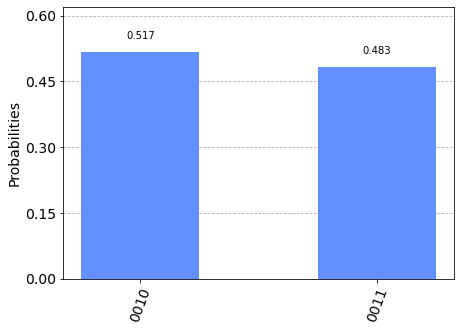

In [63]:
# Trotterization
time_evolution_operator=H*t
time_evolution_operator=time_evolution_operator.exp_i()
full_time_evolution_circuit=PauliTrotterEvolution().convert(time_evolution_operator)
full_time_evolution_circuit=full_time_evolution_circuit.bind_parameters({t:time_step_value_t})
for i in range(steps_t-1):
    full_time_evolution_circuit@=PauliTrotterEvolution().convert(time_evolution_operator)
    full_time_evolution_circuit=full_time_evolution_circuit.bind_parameters({t:time_step_value_t})
full_time_evolution_circuit=full_time_evolution_circuit.to_circuit()
full_time_evolution_circuit=harmonic_oscillator.compose(full_time_evolution_circuit)

mygate = full_time_evolution_circuit.to_gate()
qc = qc.compose(mygate,index)

# Final state

final_state = qi.Statevector.from_instruction(qc)
qc.measure(index,index)
backend = Aer.get_backend('qasm_simulator') 
job=execute(qc, backend, shots=1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [64]:
#Circuit 
# qc.decompose().decompose().decompose().draw('mpl')

In [65]:
print("True depth of the circuit is : ", depth(qc))

True depth of the circuit is :  47


FINAL STATE

In [66]:
final_state.draw('latex', prefix='State:')

<IPython.core.display.Latex object>

EXTRACTING THE INDICES FOR THE BASIS STATES



In [97]:
#Getting the indices for the one hot basis vectors from binary 
def checker(string):
  temp = []
  start = 0
  for i in range(N):
    temp.append(string[start:start+Np+1])
    start += Np+1
  temp1 = np.zeros(N)
  for i in range(N):
    for j in range(Np+1):
      temp1[i] += int(temp[i][j])
  for i in range(N):
    if temp1[i]!=1:
      return 0 
  else :
    return 1 

index2 = []
for i in range(2**((Np+1)*N)):
  temp = bin(i)[2:]    
  while (len(temp)<N*(Np+1)):
    temp = '0' + temp
  if (checker(temp)):
    index2.append(temp)
for i in range(len(index2)):
  index2[i] = int(index2[i],2)

In [98]:
#Extracting the useful matrix elements

h_list = np.zeros((N,(Np+1)**N,(Np+1)**N),dtype=complex)
num_list = np.zeros((N,(Np+1)**N,(Np+1)**N),dtype=complex)
_x_list = np.zeros((N,(Np+1)**N,(Np+1)**N),dtype=complex)
_p_list = np.zeros((N,(Np+1)**N,(Np+1)**N),dtype=complex)

for osc in range(N):
  for i,row in enumerate(index2):
    for j,column in enumerate(index2):
      h_list[osc][i][j] = H_list[osc][row][column]
      num_list[osc][i][j] = Num_list[osc][row][column]
      _x_list[osc][i][j] = _X_list[osc][row][column]
      _p_list[osc][i][j] = _P_list[osc][row][column]

In [99]:
#Extracting the useful states
final_state = np.array(final_state)

u = np.zeros((Np+1)**N,dtype = 'complex_')

for k,i in enumerate(index2):
  u[k] = final_state[i]

#Getting the Expectation Values of obsevables

exp_x = u.conjugate().T @ _x_list @ u
exp_p = u.conjugate().T @ _p_list @ u
exp_h = u.conjugate().T @  h_list @ u
exp_n = u.conjugate().T @  num_list @ u

EXPECTATION VALUES

In [100]:
print("Expectation Value of x : " , exp_x.real)
print("Expectation Value of p : " , exp_p.real)
print("Expectation Value of h : " , exp_h.real)
print("Expectation Value of n : " , exp_n.real)

Expectation Value of x :  [6.71866157e-01 2.67652511e-02 5.74295821e-04]
Expectation Value of p :  [-0.21270146  0.14558297  0.00558917]
Expectation Value of h :  [1.03664821 1.83196716 1.39339868]
Expectation Value of n :  [0.53710353 0.08411452 0.01945687]


In [101]:
 # Getting the expectation values for an interval and plotting them
t_initial = 0
t_final = t_initial + 2*np.pi

t_ = np.arange(t_initial,t_final,0.3)
no_points = np.shape(t_)[0]

_x_ = np.zeros((no_points,N))
_p_ = np.zeros((no_points,N))
_h_ = np.zeros((no_points,N))

time_elapsed = np.zeros(no_points)
depth_time = np.zeros(no_points)
steps_time = np.zeros(no_points)

print("Total Iterations = ",no_points,"\n\n")
for i in range(no_points):
  QC = QuantumCircuit(num_qubits,num_qubits)
  HARMONIC_OSCILLATOR_circuit = QuantumCircuit(num_qubits)


  mygate1 = statec.to_gate()
  index = list(np.arange(0,num_qubits,1))
  QC = QC.compose(mygate1,index)
  steps_t = int(t_[i]/time_step_value_t)

  steps_time[i] = steps_t

  start = time.time()

  time_evolution_operator=H*t
  time_evolution_operator=time_evolution_operator.exp_i()
  full_time_evolution_circuit=PauliTrotterEvolution().convert(time_evolution_operator)
  full_time_evolution_circuit=full_time_evolution_circuit.bind_parameters({t:time_step_value_t})
  for j in range(steps_t-1):
      full_time_evolution_circuit@=PauliTrotterEvolution().convert(time_evolution_operator)
      full_time_evolution_circuit=full_time_evolution_circuit.bind_parameters({t:time_step_value_t})
  full_time_evolution_circuit=full_time_evolution_circuit.to_circuit()
  full_time_evolution_circuit=HARMONIC_OSCILLATOR_circuit.compose(full_time_evolution_circuit)
  mygate = full_time_evolution_circuit.to_gate()
  index = list(np.arange(0,num_qubits,1))
  QC = QC.compose(mygate,index)

  stv = qi.Statevector.from_instruction(QC)
    
  sim = QasmSimulator()
  options = {'method': 'statevector'}
  execute(QC, sim, backend_options=options)
  
  stv = np.array(stv)
  u = np.zeros((Np+1)**N,dtype = 'complex_')

  for k,j in enumerate(index2):
    u[k] = stv[j]    

  _x_[i] = (u.conjugate().T @ _x_list @ u).real
  _p_[i] = (u.conjugate().T @ _p_list @ u).real
  _h_[i] = (u.conjugate().T @  h_list @ u).real
  

  end = time.time()
  time_elapsed[i] = end-start
  depth_time[i] = depth(QC)

  txt="iter no :{:<4}|iter time : {:10.5f}|Depth : {:<10}|Steps :{:<5}|"
  print(txt.format(i+1,time_elapsed[i],depth_time[i],steps_time[i]))
  

print("\n\n")
print("Total time taken = ",np.sum(time_elapsed)," s")

Total Iterations =  21 


iter no :1   |iter time :    2.62737|Depth : 808.0     |Steps :0.0  |
iter no :2   |iter time :    4.59142|Depth : 1611.0    |Steps :2.0  |
iter no :3   |iter time :   11.35612|Depth : 4020.0    |Steps :5.0  |
iter no :4   |iter time :   18.14406|Depth : 6429.0    |Steps :8.0  |
iter no :5   |iter time :   24.98824|Depth : 8838.0    |Steps :11.0 |
iter no :6   |iter time :   34.82176|Depth : 12050.0   |Steps :15.0 |
iter no :7   |iter time :   38.28608|Depth : 13656.0   |Steps :17.0 |
iter no :8   |iter time :   46.93392|Depth : 16868.0   |Steps :21.0 |
iter no :9   |iter time :   51.99330|Depth : 18474.0   |Steps :23.0 |
iter no :10  |iter time :   58.01807|Depth : 20883.0   |Steps :26.0 |
iter no :11  |iter time :   66.50496|Depth : 24095.0   |Steps :30.0 |
iter no :12  |iter time :   73.65457|Depth : 25701.0   |Steps :32.0 |
iter no :13  |iter time :   77.19546|Depth : 28110.0   |Steps :35.0 |
iter no :14  |iter time :   87.43103|Depth : 31322.0   |Steps :3

In [102]:
_x_ = _x_.T
_p_ = _p_.T
_h_ = _h_.T

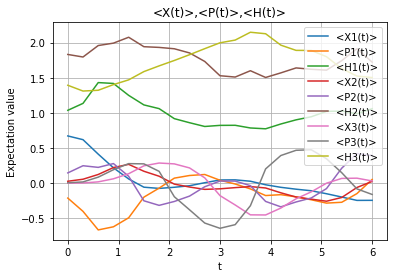

In [103]:
for i in range(N):
  plt.plot(t_,_x_[i],label="<X"+str(i+1)+"(t)>")
  plt.plot(t_,_p_[i],label="<P"+str(i+1)+"(t)>")
  plt.plot(t_,_h_[i],label="<H"+str(i+1)+"(t)>")

plt.xlabel('t')
plt.ylabel('Expectation value')
plt.legend(loc="upper right")
plt.title('<X(t)>,<P(t)>,<H(t)>')
plt.grid()
# plt.savefig('Fig1(lamda=0.01)(nosup)(x^3).svg', format='svg', dpi=1200)

In [104]:
print(np.sum(_h_)/63)

1.4947515098595305


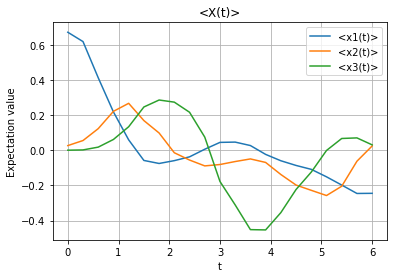

In [105]:
for i in range(N):
  plt.plot(t_,_x_[i],label="<x"+str(i+1)+"(t)>")
plt.xlabel('t')
plt.ylabel('Expectation value')
plt.legend(loc="upper right")
plt.title('<X(t)>')
plt.grid()
plt.show()

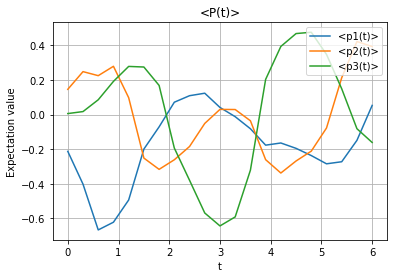

In [106]:
for i in range(N):
  plt.plot(t_,_p_[i],label="<p"+str(i+1)+"(t)>")
plt.xlabel('t')
plt.ylabel('Expectation value')
plt.legend(loc="upper right")
plt.title('<P(t)>')
plt.grid()
plt.show()

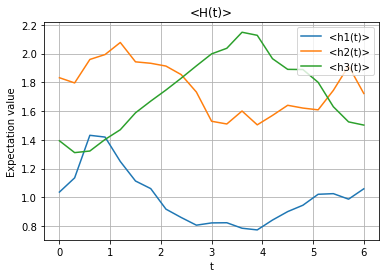

In [107]:
for i in range(N):
  plt.plot(t_,_h_[i],label="<h"+str(i+1)+"(t)>")
plt.xlabel('t')
plt.ylabel('Expectation value')
plt.legend(loc="upper right")
plt.title('<H(t)>')
plt.grid()
plt.show()

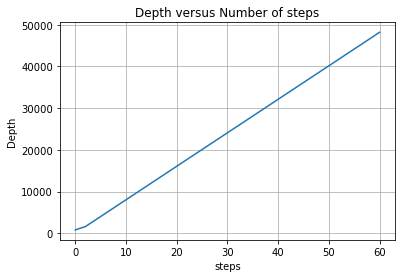

In [108]:
plt.plot(steps_time,depth_time)
plt.xlabel('steps')
plt.ylabel('Depth')
plt.title('Depth versus Number of steps')
plt.grid()
plt.show()

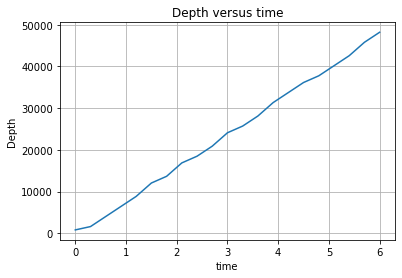

In [109]:
plt.plot(t_,depth_time)
plt.xlabel('time')
plt.ylabel('Depth')
plt.title('Depth versus time')
plt.grid()
plt.show()

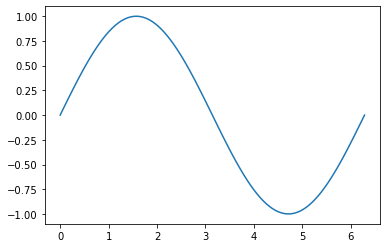

In [110]:
bazinga = np.linspace(0,2*np.pi,100)
double_bazinga = np.sin(bazinga)
plt.plot(bazinga,double_bazinga)
plt.savefig('myimage.svg', format='svg', dpi=1200)